In [7]:
import matplotlib.pyplot as plt
import json
import numpy as np 
import glob
import os 
import re
from copy import deepcopy
import matplotlib
from matplotlib.lines import Line2D
from matplotlib.backends.backend_pdf import PdfPages
from cycler import cycler

In [8]:
def format_json(json, formatter):
    for key, val in json.items():
        if key in formatter.keys():
            json[key] = formatter[key](val)
    return json

In [9]:
def get_frame_id(path):
    path = os.path.basename(path)
    return re.findall(r'[0-9][0-9][0-9][0-9][0-9]',path)[0]

In [10]:
def get_valid_grid_vrel(path, valid_set):
    paths = sorted(list(glob.glob(path)))
    #print(paths)
    vrel_list = []
    for path in paths:
        with open(path,'r') as json_file:
            frame = json.load(json_file)
            if get_frame_id(frame['rhop-path']) in valid_set:
                formatter = {
                    'binEdges':np.array,
                    'binCenters':np.array,
                    'velc_sum': np.array,
                    'velc_rad_sum': np.array
                }
                format_json(frame,formatter)
                frame['rel_velc'] = np.sqrt(frame['velc_sum'])
                frame['rel_velc_rad'] = np.sqrt(frame['velc_rad_sum'])
                vrel_list.append(deepcopy(frame))
            del frame
    return vrel_list

In [18]:
def get_valid_part_vrel(path):
    
    try:
        with open(path,'r') as json_file:
            stats = json.load(json_file)
            #print(stats)
            formatter = {
                'binEdges': np.array,
                'binCenters': np.array,
                'partCounts': np.array,
                'velocitySum': np.array,
            }
            format_json(stats,formatter)
            stats['rel_velc'] = np.sqrt(stats['velocitySum']/stats['partCounts'])
    except:
        print(path,type(path))

    return stats

In [20]:
normal = get_valid_part_vrel('/mnt/home/tchan1/ceph/particle-stats/normal/RDFVelocityTest.json')
normal_grid = get_valid_grid_vrel('/mnt/home/tchan1/ceph/grid-stats/tgt-normal/*.json',['00100'])[0]

In [22]:
#normal['rel_velc'],normal_grid['rel_velc']

In [24]:
## Color
mycolors = ['#785EF0', '#DC267F', '#FFB000']

In [26]:
part_vrel = dict(
    normal=dict(
        path='/mnt/home/tchan1/ceph/particle-stats/normal/RDFVelocityTest.json',
        frame='00100',
        label='PART',
        color=mycolors[0],
    ),
    kdrive38=dict(
        path='/mnt/home/tchan1/ceph/particle-stats/kdrive3-8/RDFVelocityTest.json',
        frame='00010',
        label='PART',
        color=mycolors[0],
    ),
    dedt5e4=dict(
        path='/mnt/home/tchan1/ceph/particle-stats/dedt5e-4/RDFVelocityTest.json',
        frame='00010',
        label='PART',
        color=mycolors[0],
    ),
    ts0001=dict(
        path='/mnt/home/tchan1/ceph/particle-stats/ts0.001/RDFVelocityTest.json',
        frame='00100',
        label='PART',
        color=mycolors[0],
    )
)

In [43]:
grid_vrel = dict(
    normal=dict(
        path='/mnt/home/tchan1/ceph/grid-stats/tgt-normal/*.json',
        frame='00100',
        label='GRID',
        plot=0,
        tgt='normal',
        color=mycolors[1],
    ),
    kdrive38=dict(  
        path='/mnt/home/tchan1/ceph/grid-stats/tgt-kdrive3-8/*.json',
        frame='00010',
        label='GRID',
        plot=1,
        tgt='kdrive38',
        color=mycolors[1],
    ),
    dedt5e4=dict(
        path='/mnt/home/tchan1/ceph/grid-stats/tgt-dedt5e-4/*.json',
        frame='00010',
        label='GRID',
        plot=2,
        tgt='dedt5e4',
        color=mycolors[1],
    ),
    ts0001=dict(
        path='/mnt/home/tchan1/ceph/grid-stats/tgt-ts0.001/*.json',
        frame='00100',
        label='GRID',
        plot=3,
        tgt='ts0001',
        color=mycolors[1],
    )
)

In [44]:
title_dict = dict(
    normal=dict(
        title='Normal',
        plot=0
    ),
    kdrive38=dict(
        title=r'$k_{min},k_{max}=3,8$',
        plot=1,
    ),
    dedt5e4=dict(
        title=r'$\langle\dot{e}\rangle = 5\times 10^{-4}$',
        plot=2,
    ),
    ts0001=dict(
        title=r'$\tau_s=0.001$',
        plot=3,
    )
)

In [45]:
for tgt_key, meta in part_vrel.items():
    stats = get_valid_part_vrel(meta['path'])
    meta['data']=deepcopy(stats)

In [46]:
for out_key, meta in grid_vrel.items():
    stats = get_valid_grid_vrel(meta['path'],[meta['frame']])[0]
    meta['data'] = deepcopy(stats)

In [62]:
plot_spec = dict(
    nrows=2, ncols=4,
    constrained_layout=True,
    sharex='col',sharey='row',
    dpi=600,
    figsize=(10,5.5)
)

In [63]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Helvetica"]})

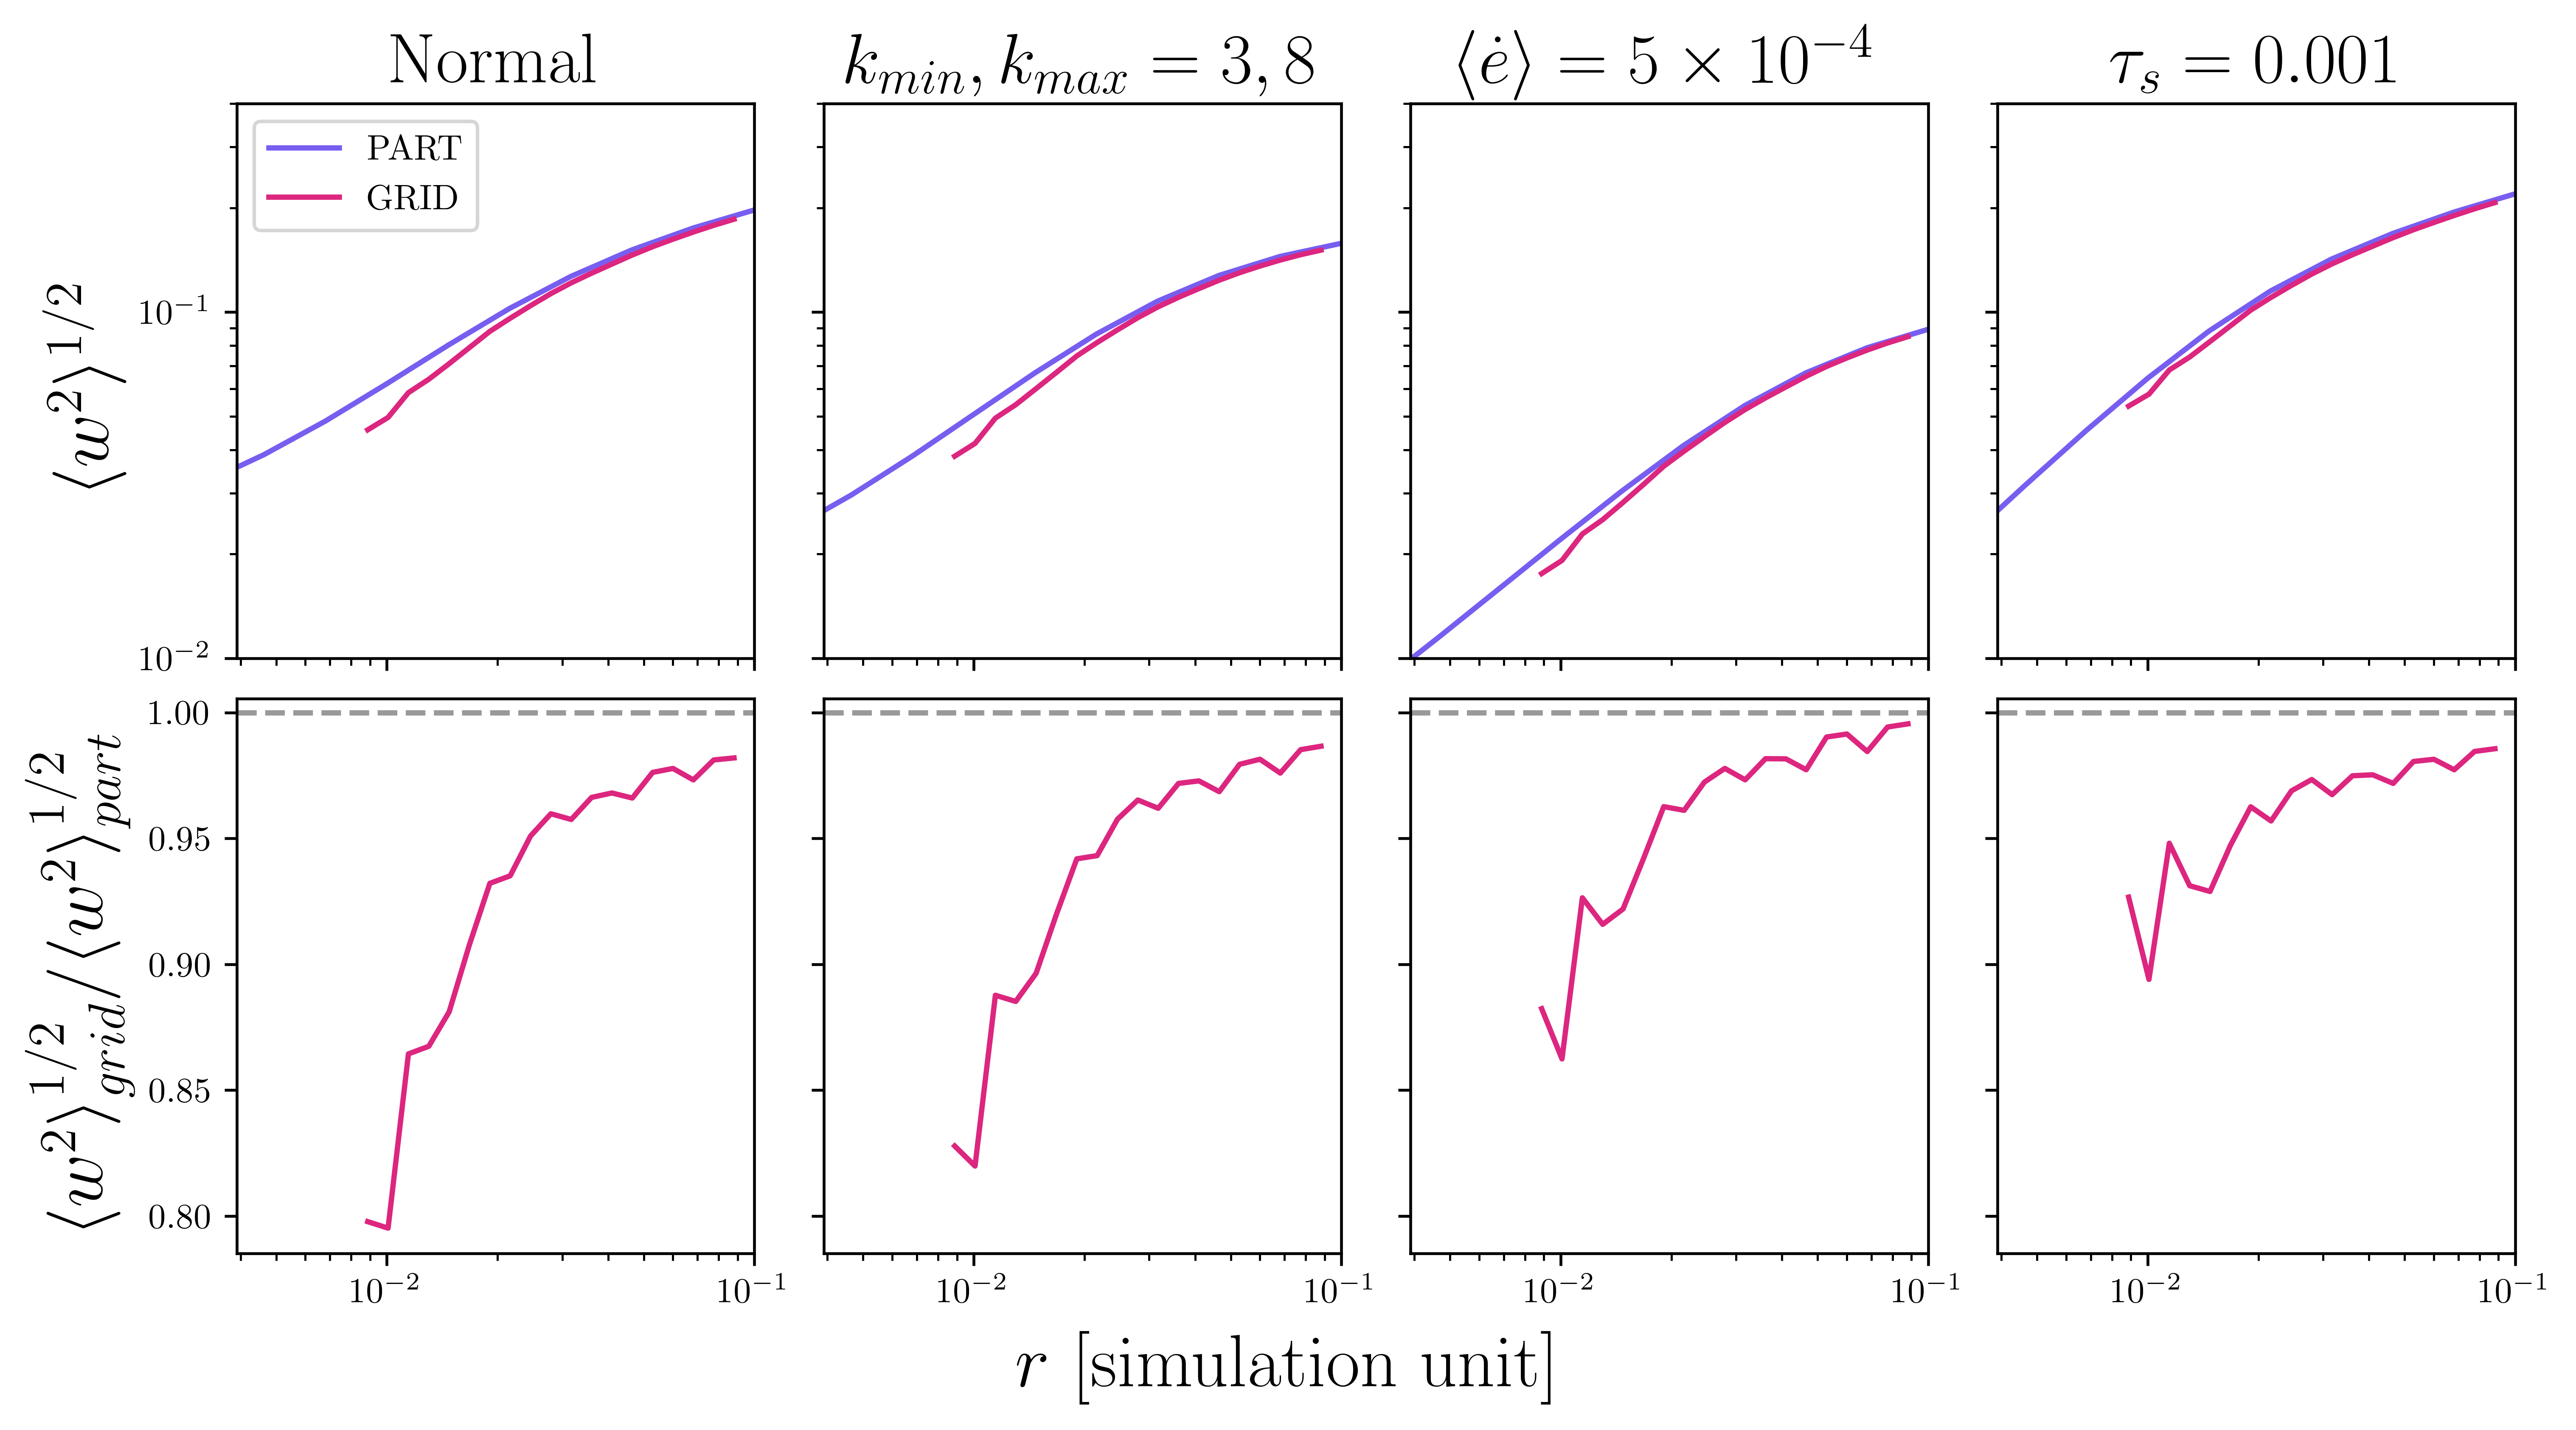

In [64]:
with PdfPages('vrel_part_vs_grid.pdf') as pdf:
    fig, axs = plt.subplots(**plot_spec)


    # Plot all the targets
    for i, (tgt_key, meta) in enumerate(part_vrel.items()):
        axs[0][i].plot(meta['data']['binCenters'],meta['data']['rel_velc'],
                       label=meta['label'],color=meta['color'])

    # Plot all outputs
    for out_key, meta in grid_vrel.items():
        axs[0][meta['plot']].plot(meta['data']['binCenters'],meta['data']['rel_velc'],
                                  label=meta['label'],color=meta['color'])
        #axs[0][meta['plot']].legend()

    # Plot all ratios
    for out_keys, meta in grid_vrel.items():
        tgt = part_vrel[meta['tgt']]
        tgt_vrel = np.interp(meta['data']['binCenters'], tgt['data']['binCenters'], tgt['data']['rel_velc'])
        axs[1][meta['plot']].plot(meta['data']['binCenters'],
                                  meta['data']['rel_velc']/tgt_vrel,
                                  label='{}/{}'.format(meta['label'],tgt['label']),
                                  color=meta['color']
                                 )
        #axs[1][meta['plot']].legend()

    # Zoom-in plot
    """axin1 = axs[1][3].inset_axes([0.18, 0.15, 0.3, 0.3])
    axin1.plot(meta['data']['binCenters'],meta['data']['RDF']/tgt['data']['RDF'],color=meta['color'])#,label=meta['label'])
    axin1.set_xlim(1/256,3e-2)
    axin1.set_ylim(1.75,2.5)
    axin1.set_xscale('log')
    axin1.set_xticks([0.4e-2,3e-2])
    axin1.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
    #zoom_line1 = Line2D([0.18,1],[0.15,0.15+1])
    #axs[1][3].add_line(zoom_line1)
    #axs[1][3].indicate_inset_zoom(axin1, edgecolor="grey")"""

    # Plotting configurations for row 0
    for i,ax in enumerate(axs[0]):
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_ylim(1e-2,0.4)
        ax.axhline(1,ls='--',color='grey',alpha=0.8)
        if i == 0:
            ax.legend()

    for i,ax in enumerate(axs[1]):
        ax.axhline(1,ls='--',color='grey',alpha=0.8)

        ax.set_xlim(1/256,0.1)
        if i == 0:
            pass
            #ax.legend()
    for title_key, meta in title_dict.items():
        axs[0][meta['plot']].set_title(meta['title'],fontsize=20)

    fig.supxlabel(r'$r$ [simulation unit]',fontsize=21)
    axs[0][0].set_ylabel(r'$\langle w^{2}\rangle^{1/2}$',fontsize=21)
    axs[1][0].set_ylabel(r'$\langle w^{2}\rangle^{1/2}_{grid}/\langle w^{2}\rangle^{1/2}_{part}$',fontsize=21)
    #axs[0][1].set_title('')

    pdf.savefig(fig)
    